In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as ss
import csv
import numpy as np
import sklearn
import glob
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

### CONVERTIR PACIENTES (los 1794 csv de la carpeta pacientes) A UNA LISTA Y LA LISTA A CSV

In [2]:
import os
#contenido = os.listdir('C:/Users/ywen2/Desktop/URJC/TFG/TFG_Progresion_Diabetes/GitHub/TFG/ddbb/pacientes')

contenido = os.listdir('./pacientes')

In [3]:
# Primero especificamos un patrón del archivo y lo pasamos como parámetro en la función glob
# Se que es redundante crear dos listas, pero es la única forma de trabajar con PANDAS, debo revisarlo!!!!!!!!!!!
lista_id_indep =  [item.replace(".csv", "") for item in contenido]
# Mostrar el archivo csv_files, el cual es una lista de nombres
#print(lista_id_indep)
pacientes_independientes = pd.DataFrame(lista_id_indep, columns=["Pacientes"])
pacientes_independientes.to_csv('pacientes_indep.csv', index=False)
df_independientes = pd.read_csv('pacientes_indep.csv').fillna(0)
pacientes_independientes = df_independientes.iloc[:,0]
pacientes_independientes = list(pacientes_independientes)

### CREO UNA LISTA A PARTIR DEL CSV PACIENTES PROGRESORES

In [4]:
with open('pacientes_progresores.csv', 'r') as archivo:
    leer = csv.reader(archivo)
    lista = list(leer)
    lista.pop(0)
    #print(lista)

In [5]:
df = pd.DataFrame (lista,columns=['Historia','Progresion'])
print (df)

     Historia Progresion
0      100220          1
1      100257          0
2       10045          0
3      100505          0
4      100598          0
...       ...        ...
1642    99582          0
1643     9970          0
1644    99828          1
1645    99835          0
1646     9985          0

[1647 rows x 2 columns]


In [6]:
df_progresores = pd.read_csv('pacientes_progresores.csv').fillna(0)
pacientes_progresores = df_progresores.iloc[:,0]
#print(pacientes_progresores)
pacientes_progresores = list(pacientes_progresores)
#print(pacientes_progresores)

### COMPARO AMBAS LISTAS Y ELIMINO PACIENTES NO COINCIDENTES Y CREO EL CSV CON AQUELLOS PACIENTES QUE COINCIDEN EN AMBAS LISTAS

In [7]:
comparacion = []
 
for item in pacientes_independientes:
    if item in pacientes_progresores:
        comparacion.append(item)

In [8]:
df_procesados = pd.DataFrame(comparacion, columns=["Historia"])
print(df_procesados)
df_procesados.to_csv('pacientes_procesados.csv', index=False)

      Historia
0       139201
1       373199
2       296856
3       173427
4         3942
...        ...
1642     42439
1643    128011
1644     69198
1645     50927
1646    213635

[1647 rows x 1 columns]


## AHORA QUIERO COMPARAR EL CSV PACIENTES PROGRESORES CON PACIENTES PROCESADOS Y EN AQUELLOS PACIENTES QUE COINCIDAN AÑADIR AL CSV  PACIENTES PROCESADOS LA ETIQUETA 1 o 0 QUE ACOMPAÑA A CADA NUMERO DE HISTORIA EN EL CSV PACIENTES PROGRESORES . NO SE HACERLO :(

In [9]:
file1 = df['Historia'].astype(int)

In [10]:
file2 = df_procesados['Historia'].astype(int)

In [11]:
mergedStuff = pd.merge(file1, file2, how='inner', indicator = 'union')
print(mergedStuff)

contador = 0
for i in mergedStuff['union']:
    if i != 'both':
        contador += 1
        
print(contador)

      Historia union
0       100220  both
1       100257  both
2        10045  both
3       100505  both
4       100598  both
...        ...   ...
1642     99582  both
1643      9970  both
1644     99828  both
1645     99835  both
1646      9985  both

[1647 rows x 2 columns]
0


#### EN EL FICHERO PACIENTES_PROGRESORES TENEMOS TODOS LOS PACIENTES A ESTUDIAR

## ESCRITO POR OSCAR

1. Lista de csv de los nombres de ficheros HECHO
1. Ver coincidencias de lista con progresión y lista de ficheros HECHO
1. Generar un dataframe con n_historia y con variable targer (progresion) NOS SIRVE PACIENTES_PROCESADOS

df['id'] #columna de identificación
df['progresion_diab'] = #target

df lista de pacientes que tenemos la variable y y tenemos datos.

1. Si estamos con la solución ajustar regresión polinómica

 1.pinta 5 pacientes progresores y cinco no progresores

pat_id = 5050

Plots de variables vs revisiones


X_prog = list de matrices(mxn) filas= revisiones, columnas= variables, 



X_no_prog


In [15]:
def get_pat(idd,path='./pacientes/'):
    
    file = df.values.tolist()
    paciente = pd.read_csv(path + idd+'.csv')
    for i in file:
        if i[0] == idd:
            print('El paciente presenta la siguiente etiqueta:', i[1])
    return(paciente)
    
    #lee fichero de ese id
    

In [16]:
paciente = get_pat('100220')
paciente1 = get_pat('15015')
paciente2 = get_pat('13563')
paciente3 = get_pat('153504')
paciente4 = get_pat('224674')
paciente5 = get_pat('9985')
paciente6 = get_pat('5526')
paciente7 = get_pat('7658')
paciente8 = get_pat('12170')
paciente9 = get_pat('390511')

El paciente presenta la siguiente etiqueta: 1
El paciente presenta la siguiente etiqueta: 1
El paciente presenta la siguiente etiqueta: 1
El paciente presenta la siguiente etiqueta: 1
El paciente presenta la siguiente etiqueta: 1
El paciente presenta la siguiente etiqueta: 0
El paciente presenta la siguiente etiqueta: 0
El paciente presenta la siguiente etiqueta: 0
El paciente presenta la siguiente etiqueta: 0
El paciente presenta la siguiente etiqueta: 0


In [17]:
X = np.matrix(paciente)
X1 = np.matrix(paciente1)
X2 = np.matrix(paciente2)
X3 = np.matrix(paciente3)
X4 = np.matrix(paciente4)
X5 = np.matrix(paciente5)
X6 = np.matrix(paciente6)
X7 = np.matrix(paciente7)
X8 = np.matrix(paciente8)
X9 = np.matrix(paciente9)

#X = np.transpose(X)
#print(X)

<ipython-input-27-0b39185de59b>:73: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(X_no_progresores[:,:,i],axis = 0),color ='k',linewidth = 3,label = 'No progresores')
<ipython-input-27-0b39185de59b>:73: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(X_no_progresores[:,:,i],axis = 0),color ='k',linewidth = 3,label = 'No progresores')
<ipython-input-27-0b39185de59b>:73: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(X_no_progresores[:,:,i],axis = 0),color ='k',linewidth = 3,label = 'No progresores')
<ipython-input-27-0b39185de59b>:73: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(X_no_progresores[:,:,i],axis = 0),color ='k',linewidth = 3,label = 'No progresores')


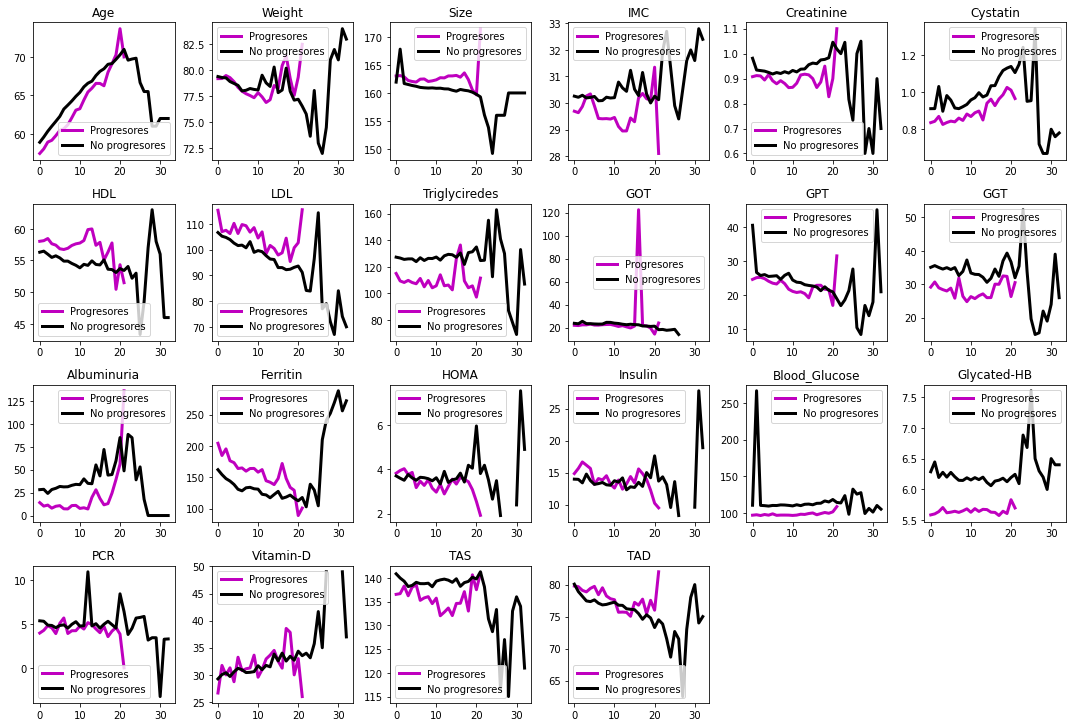

In [27]:
progresores = []
no_progresores = []
fila = []
for i in df.index:
    if df['Progresion'][i] == '1':
         progresores.append((df['Historia'][i]))
    else:
        no_progresores.append((df['Historia'][i]))


row_max = 0
row_max_1 = 0
matrices = [] #list of matrices. Each list element is a matrix for one patient, with rows = reviews, cols = features
matrices_1 = [] #list of matrices. Each list element is a matrix for one patient, with rows = reviews, cols = features

for paciente in progresores:
        pacientes = pd.read_csv('./pacientes/' + paciente+'.csv',usecols = list(range(22))) #dataframe con variables.
        #remove last column (date)
        matrix_pat = pacientes.to_numpy() #one patient matrix
        matrices.append(matrix_pat)
        #print(len(matrices))
        
        #get the maximum number of rows : it is the maiximum number of reviews for a given patient.
        filas = matrix_pat.shape[0]
        if filas > row_max:
            row_max = filas
            
            
for paciente in no_progresores:
    pacientes = pd.read_csv('./pacientes/' + paciente+'.csv',usecols = list(range(22)))
        #remove last column (date)
    matrix_pat_1 = pacientes.to_numpy() #one patient matrix
    matrices_1.append(matrix_pat_1)
        #print(len(matrices))
        
        #get the maximum number of rows : it is the maiximum number of reviews for a given patient.
    filas_1 = matrix_pat_1.shape[0]
    if filas_1 > row_max_1:
        row_max_1 = filas_1
        

        
        
        
        
  #build complete matrix
     
X_progresores = np.zeros((len(matrices),row_max,22))
X_progresores[:,:,:] = np.nan

for i,mat in enumerate(matrices):
    X_progresores[i,:mat.shape[0],:] = mat
    
X_no_progresores = np.zeros((len(matrices_1),row_max_1,22))
X_no_progresores[:,:,:] = np.nan

for i,mat_1 in enumerate(matrices_1):
    X_no_progresores[i,:mat_1.shape[0],:] = mat_1
    



        
plt.figure(figsize = (15,15))

#__ = plt.plot(X[:,:,13].T,linewidth = 0.1,color = [.5]*3)
feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

for i in range(len(feature_names)-1):

    plt.subplot(6,6,i+1)  
    plt.plot(np.nanmean(X_progresores[:,:,i],axis = 0),color ='m',linewidth = 3,label = 'Progresores')
    plt.plot(np.nanmean(X_no_progresores[:,:,i],axis = 0),color ='k',linewidth = 3,label = 'No progresores') 
    plt.title(feature_names[i])
    plt.legend()
  


plt.tight_layout()


# Plotting mean values for each feature along the reviews

In [19]:
def get_matrix():
    progresores = []
    no_progresores = []
    fila = []
    for i in df.index:
        if df['Progresion'][i] == '1':
             progresores.append((df['Historia'][i]))
        else:
            no_progresores.append((df['Historia'][i]))

    row_max = 0
    row_max_1 = 0
    matrices = [] #list of matrices. Each list element is a matrix for one patient, with rows = reviews, cols = features
    matrices_1 = [] #list of matrices. Each list element is a matrix for one patient, with rows = reviews, cols = features

    for paciente in progresores:
            pacientes = pd.read_csv('./pacientes/' + paciente+'.csv',usecols = list(range(22))) #dataframe con variables.
            #remove last column (date)
            matrix_pat = pacientes.to_numpy() #one patient matrix
            matrices.append(matrix_pat)
            #print(len(matrices))

            #get the maximum number of rows : it is the maiximum number of reviews for a given patient.
            filas = matrix_pat.shape[0]
            if filas > row_max:
                row_max = filas


    for paciente in no_progresores:
        pacientes = pd.read_csv('./pacientes/' + paciente+'.csv',usecols = list(range(22)))
            #remove last column (date)
        matrix_pat_1 = pacientes.to_numpy() #one patient matrix
        matrices_1.append(matrix_pat_1)
            #print(len(matrices))

            #get the maximum number of rows : it is the maiximum number of reviews for a given patient.
        filas_1 = matrix_pat_1.shape[0]
        if filas_1 > row_max_1:
            row_max_1 = filas_1


      #build complete matrix

    X_progresores = np.zeros((len(matrices),row_max,22))
    X_progresores[:,:,:] = np.nan

    for i,mat in enumerate(matrices):
        X_progresores[i,:mat.shape[0],:] = mat

    X_no_progresores = np.zeros((len(matrices_1),row_max_1,22))
    X_no_progresores[:,:,:] = np.nan

    for i,mat_1 in enumerate(matrices_1):
        X_no_progresores[i,:mat_1.shape[0],:] = mat_1

    
    
    return X_progresores, X_no_progresores

In [20]:
matriz_progresores, matriz_no_progresores = get_matrix()

In [21]:
print(matriz_progresores.shape)

(132, 22, 22)


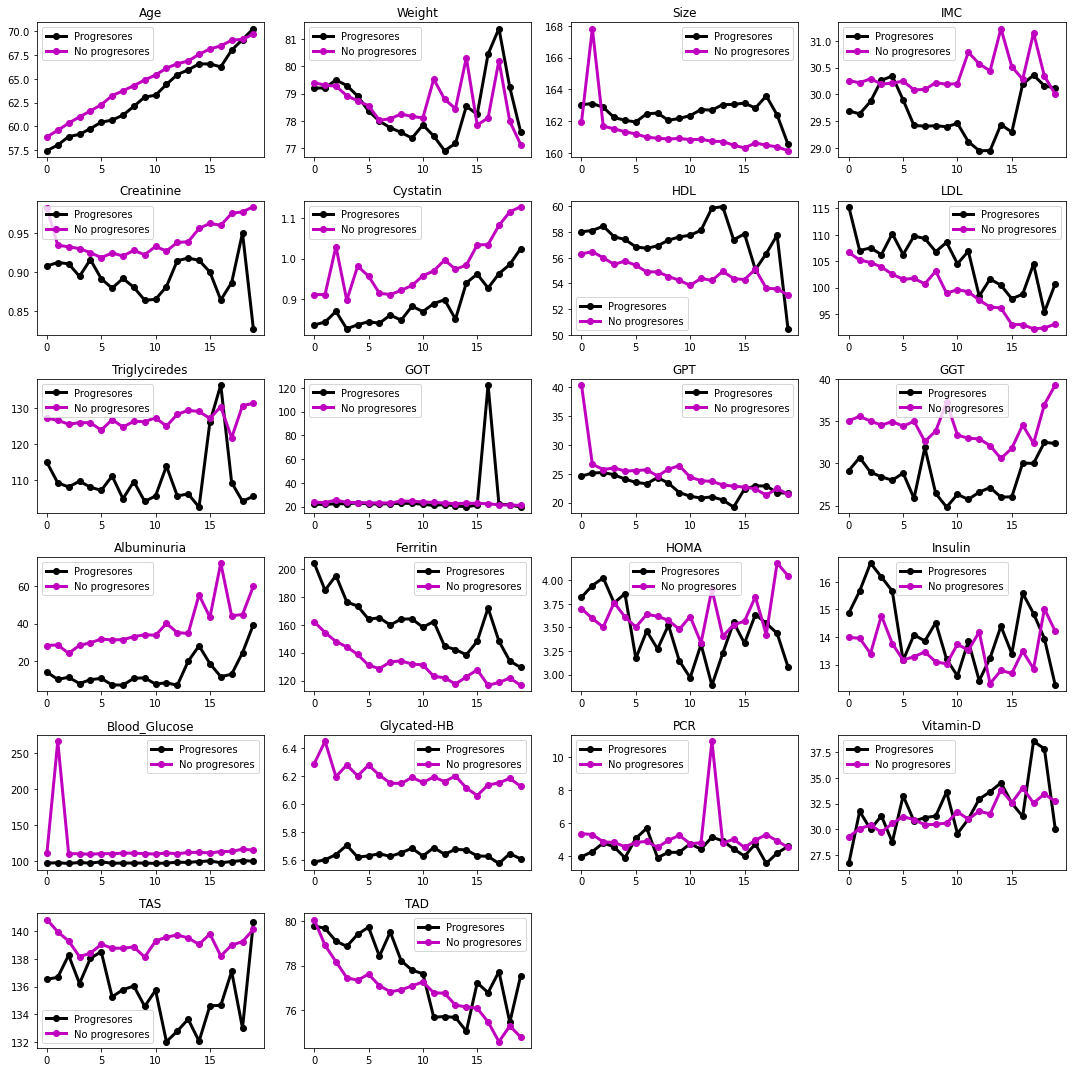

In [22]:
feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
plt.figure(figsize = (15,15))
for i in range(len(feature_names)-1):

    plt.subplot(6,4,i+1)  
    plt.plot(np.nanmean(matriz_progresores[:,:20,i],axis = 0),'k-o',linewidth = 3,label = 'Progresores')
    plt.plot(np.nanmean(matriz_no_progresores[:,:20,i],axis = 0),'m-o',linewidth = 3,label = 'No progresores') 
    plt.title(feature_names[i])
    plt.legend()

plt.tight_layout()

* CUANTOS PACIENTES TIENEN MÁS DEL MAXIMO DE REVISIONES DE LOS PROGRESORES
* TABLA/GRAFICA DE PACIENTES PROGRESORES Y NO PROGRESORES SEGUN EL NÚMERO DE REVISIONES

* EN AQUELLAS GRÁFICAS QUE HAY PICOS REVISAR, Vamos a ver todas las revisiones para cada features en un jupyternotebooo diferente
* Para todas las revisiones:PINTAR HISTOGRAMA O BOX PLOT 
* MATRIZ CON LAS MISMAS DIMENSIONES QUE MATRIZ NO/PROGRESORES. LA CREO CON TODO TRUE, EN CADA FEATURE Y REVISION QUE MODIFIQUE 

* PINTAR GRAFICAS SIN LOS OUTLIERS.

* Número de pacientes por revisión!!!

#### MATRIZ DE ÍNDICES

In [ ]:
outliers_limits = [[low_age,upper_age] , [] 
                   

In [ ]:
for i in range (23):
    idxn = np.isnan(matriz_no_progresores[:,i,:]) #vector con True donde hay NAN
    idxoutl = (matriz_no_progresores[:,i,:] < i[1]) & (matriz_no_progresores[:,i,:] > i[0])

In [71]:
#plt.boxplot(matriz_no_progresores[:,1,17])
idxn = np.isnan(matriz_no_progresores[:,1,16]) #vector con True donde hay NAN
idxoutl = (matriz_no_progresores[:,1,16] < 200) & (matriz_no_progresores[:,1,16] > 50)

{'whiskers': [<matplotlib.lines.Line2D at 0x20db13958c8>,
 'caps': [<matplotlib.lines.Line2D at 0x20db1395f48>,
 'boxes': [<matplotlib.lines.Line2D at 0x20db1395108>],
 'medians': [<matplotlib.lines.Line2D at 0x20db1397ec8>],
 'fliers': [<matplotlib.lines.Line2D at 0x20db048ba08>],
 'means': []}

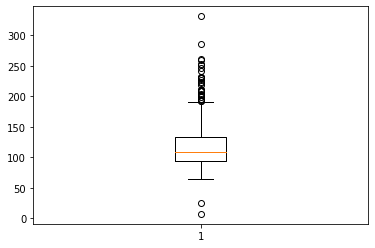

In [67]:
plt.boxplot(matriz_no_progresores[(~idxn)&(idxoutl),1,16]) 

In [72]:
idx_no_progresores = np.zeros(matriz_no_progresores.shape, dtype=bool)
idx_no_progresores[:,:,:] = True
idx_no_progresores[:,1,16] = (~idxn)&(idxoutl)
print(idx_no_progresores[:,1,16])

[ True  True  True ...  True  True  True]


In [73]:
gluc_mean = []
for i in range(30): 
    aux = np.nanmean(matriz_no_progresores[idx_no_progresores[:,i,16],i,16]) #COJO LOS PACIENTES QUE NO SON NI NAN NI MAYORES > 20 y HAGO LA MEDIA 
    gluc_mean.append(aux)

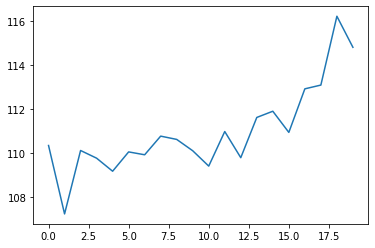

In [74]:
plt.plot(gluc_mean)

Plotting blood glucose

In [75]:
np.save('Matriz_progresores', matriz_progresores)
np.save('Matriz_no_progresores', matriz_no_progresores)

In [76]:
##UN JUPYTER PARA CADA FEATURE Y ANALIZO POR REVISION

In [ ]:
matriz_progresores = np.load('Matriz_progresores.npy') #PARA CARGAR EN OTRO JUPYTER

In [15]:
print(X_pac[0])
print(X6[:,0].flatten())

NameError: name 'X_pac' is not defined

In [23]:
X_pac = np.zeros((5,24))
X_pac[:,:] = np.nan
X_pac[0,:X5.shape[0]] = X5[:,4].flatten() #En la fila 0 y las columnas de X5.shape meteme la variable 4
X_pac[1,:X6.shape[0]] = X6[:,4].flatten()
X_pac[2,:X7.shape[0]] = X7[:,4].flatten()
X_pac[3,:X8.shape[0]] = X8[:,4].flatten()
X_pac[4,:X9.shape[0]] = X9[:,4].flatten()
X_pac

NameError: name 'X5' is not defined

<ipython-input-26-d1ea57f70ae1>:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(X_pac,axis = 0), label = 'no_progresores')
<ipython-input-26-d1ea57f70ae1>:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(X_pac,axis = 0) + np.nanstd(X_pac,axis = 0), linestyle = ':', linewidth = 0.5, color = 'k')
/home/obarquero/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-26-d1ea57f70ae1>:3: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(X_pac,axis = 0) - np.nanstd(X_pac,axis = 0), linestyle = ':', linewidth = 0.5, color = 'k')
/home/obarquero/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


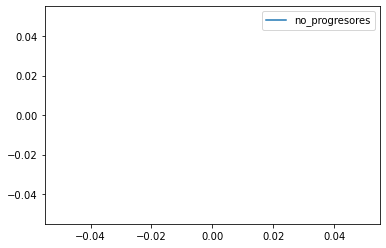

In [26]:
plt.plot(np.nanmean(X_pac,axis = 0), label = 'no_progresores')
plt.plot(np.nanmean(X_pac,axis = 0) + np.nanstd(X_pac,axis = 0), linestyle = ':', linewidth = 0.5, color = 'k')
plt.plot(np.nanmean(X_pac,axis = 0) - np.nanstd(X_pac,axis = 0), linestyle = ':', linewidth = 0.5, color = 'k')
plt.legend()
#xx = np.arange(X_pac.shape[1])
#plt.plot(xx, X_pac.T, linewidth = 0.3, color = [0.5,0.5,0.5])


In [27]:
## Analizar las 20.. variables, media y varianza de progresores y no progresores
## funcion que reciba el dataframe y el string de las varibales y que devuelva dos matrices X, una para progresores y no progresores.
## Busco el paciente con mas revisiones y hago una matriz con tantas filas como pacientes y columnas como maximo de revisiones

In [28]:
df['Historia'][df['Progresion'] == '0']
##DE LA COLUMNA HISTORIA, COJO DE LA COLUMNA DE PROGRESION AQUELLOS QUE SEAN = 0 o 1

1       100257
2        10045
3       100505
4       100598
5       100756
         ...  
1640      9926
1642     99582
1643      9970
1645     99835
1646      9985
Name: Historia, Length: 1515, dtype: object

In [29]:
import matplotlib.pyplot as plt

plt.plot(X[:,8],'o-')
plt.plot(X1[:,8]'o-')
plt.plot(X2[:,8],'o-')
plt.plot(X3[:,8],'o-')
plt.plot(X4[:,8],'o-')
plt.plot(X5[:,8],'o-')
plt.plot(X6[:,8],'o-')
plt.plot(X7[:,8],'o-')
plt.plot(X8[:,8],'o-')
plt.plot(X9[:,8],'o-')



SyntaxError: invalid syntax (<ipython-input-29-d5bb0b11d38e>, line 4)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X[:,8])
X[0]

In [ ]:
X_poly[0]
